# Summary

This notebook performs an exploratory data analysis (EDA) and builds a time series forecasting model for temperature using a global weather dataset. It then explores ensemble modeling and regional climate variations.

## Exploratory Data Analysis (EDA)

The initial EDA steps included:
- Loading the dataset from 'GlobalWeatherRepository.csv'.
- Checking for missing values, revealing that there were no missing values in the dataset.
- Identifying and counting outliers in numerical columns using the IQR method. Several columns, such as `longitude`, `temperature_celsius`, `temperature_fahrenheit`, `precip_mm`, `precip_in`, `visibility_km`, `visibility_miles`, and various air quality metrics, showed a significant number of outliers.
- Capping the identified outliers to the lower and upper bounds calculated by the IQR method.
- Scaling the numerical features using MinMaxScaler to bring them within a 0-1 range.
- Visualizing the distributions of `temperature_celsius` and `temperature_fahrenheit` using histograms. Both show roughly normal distributions after outlier capping and scaling.
- Visualizing the distributions of `precip_mm` and `precip_in` using histograms. These distributions are heavily skewed towards zero, indicating many data points with little to no precipitation.
- Creating a scatter plot to visualize the relationship between `temperature_celsius` and `precip_mm`. The plot suggests a weak negative correlation, with lower precipitation generally occurring at higher temperatures.
- Analyzing the time series trends of daily mean temperature and precipitation. Line plots show fluctuations in both temperature and precipitation over time.

## Model Building

A time series forecasting model was built to predict `temperature_celsius`:
- Time-based features (year, month, day, hour) were extracted from the `last_updated` column.
- The dataset was split into training (80,287 samples) and testing (20,072 samples) sets using an 80/20 chronological split.
- An XGBoost regressor model was trained on the training data.
- Predictions were made on the testing data.
- The model's performance was evaluated using:
    - Mean Squared Error (MSE): 0.027
    - Root Mean Squared Error (RMSE): 0.165
    - Mean Absolute Error (MAE): 0.127
- A scatter plot of actual vs. predicted temperature showed a strong correlation, with predictions generally aligning well with actual values.

## Advanced Assessment: Ensemble Modeling

An ensemble modeling approach was explored to potentially improve forecasting accuracy:
- Time-based features were prepared for ensemble modeling.
- The dataset was split into training and testing sets.
- Individual models (Linear Regression, Random Forest Regressor, ARIMA, and Prophet) were trained on the training data.
- Predictions were made by each individual model on the testing data.
- Evaluation metrics for each individual model were calculated and compared:
    - **Linear Regression:** MSE: 0.0379, RMSE: 0.1948, MAE: 0.1630
    - **Random Forest Regressor:** MSE: 0.0299, RMSE: 0.1728, MAE: 0.1345 (Best individual model)
    - **ARIMA Model:** MSE: 0.0369, RMSE: 0.1921, MAE: 0.1448
    - **Prophet Model:** MSE: 0.0462, RMSE: 0.2151, MAE: 0.1653 (Worst individual model)
- An ensemble prediction was created by averaging the predictions of the individual models.
- The ensemble model's performance was evaluated:
    - Ensemble MSE: 0.0284
    - Ensemble RMSE: 0.1684
    - Ensemble MAE: 0.1370
- A comparison of model performance showed that the ensemble model achieved the lowest MSE and RMSE, outperforming the best individual model (Random Forest). The ensemble's MAE was slightly higher than the Random Forest's MAE.
- A line plot visualized the actual temperature against the predictions from the Random Forest and Ensemble models, illustrating how closely the predictions track the actual values.

## Analyze Regional Variations

Climate patterns across selected regions were analyzed:
- Data was filtered for 'United States', 'India', 'China', 'Brazil', and 'Germany'.
- Mean temperature and precipitation were aggregated by country and month.
- Line plots were generated to visualize the long-term temperature and precipitation trends for each selected country. These plots allow for a visual comparison of climate patterns and seasonal variations across the regions.

## Overall Insights and Next Steps

- The data was successfully cleaned, preprocessed, and explored.
- Both a single XGBoost model and an ensemble of models were built for temperature forecasting. The ensemble model showed improved performance in terms of MSE and RMSE compared to individual models.
- Regional analysis provided initial insights into climate variations across different countries.
- **Next Steps:**
    - Explore more advanced ensemble techniques (e.g., weighted averaging, stacking) to potentially further improve forecasting accuracy.
    - Incorporate additional relevant features (e.g., seasonal indicators, external climate indices) into the models.
    - Perform more in-depth analysis of regional climate patterns, including statistical comparisons and investigation of factors contributing to variations.
    - Extend the time series forecasting to include precipitation or other relevant climate variables.

#EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df = pd.read_csv('GlobalWeatherRepository.csv')

In [5]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone    

In [6]:
numerical_cols = df.select_dtypes(include=np.number).columns
outlier_counts = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]
print("Number of outliers per numerical column (using IQR method):")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")

Number of outliers per numerical column (using IQR method):
latitude: 0
longitude: 7719
last_updated_epoch: 0
temperature_celsius: 3287
temperature_fahrenheit: 3298
wind_mph: 1502
wind_kph: 1624
wind_degree: 0
pressure_mb: 3104
pressure_in: 4694
precip_mm: 19019
precip_in: 15933
humidity: 0
cloud: 0
feels_like_celsius: 2692
feels_like_fahrenheit: 2664
visibility_km: 19250
visibility_miles: 19117
uv_index: 1
gust_mph: 2589
gust_kph: 2618
air_quality_Carbon_Monoxide: 9078
air_quality_Ozone: 2584
air_quality_Nitrogen_dioxide: 11043
air_quality_Sulphur_dioxide: 13546
air_quality_PM2.5: 8428
air_quality_PM10: 10697
air_quality_us-epa-index: 7904
air_quality_gb-defra-index: 10785
moon_illumination: 0


In [7]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

print("Outliers have been capped to the lower and upper bounds.")

Outliers have been capped to the lower and upper bounds.


In [8]:
from sklearn.preprocessing import MinMaxScaler

numerical_cols = df.select_dtypes(include=np.number).columns
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
display(df.head())

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,0.719014,0.705988,Asia/Kabul,0.0,2024-05-16 13:15,0.583333,0.582650,Partly Cloudy,...,0.131225,0.489767,0.0,0.0,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,0.55
1,Albania,Tirana,0.783594,0.491065,Europe/Tirane,0.0,2024-05-16 10:45,0.397059,0.396858,Partly cloudy,...,0.014857,0.311867,0.0,0.0,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,0.55
2,Algeria,Algiers,0.740256,0.418046,Africa/Algiers,0.0,2024-05-16 09:45,0.495098,0.495219,Sunny,...,0.163107,0.430467,0.0,0.0,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,0.55
3,Andorra,Andorra La Vella,0.794689,0.411384,Europe/Andorra,0.0,2024-05-16 10:45,0.085784,0.084016,Light drizzle,...,0.008481,0.303912,0.0,0.0,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,0.55
4,Angola,Luanda,0.307824,0.462371,Africa/Luanda,0.0,2024-05-16 09:45,0.568627,0.568989,Partly cloudy,...,1.000000,1.000000,1.0,1.0,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,0.55


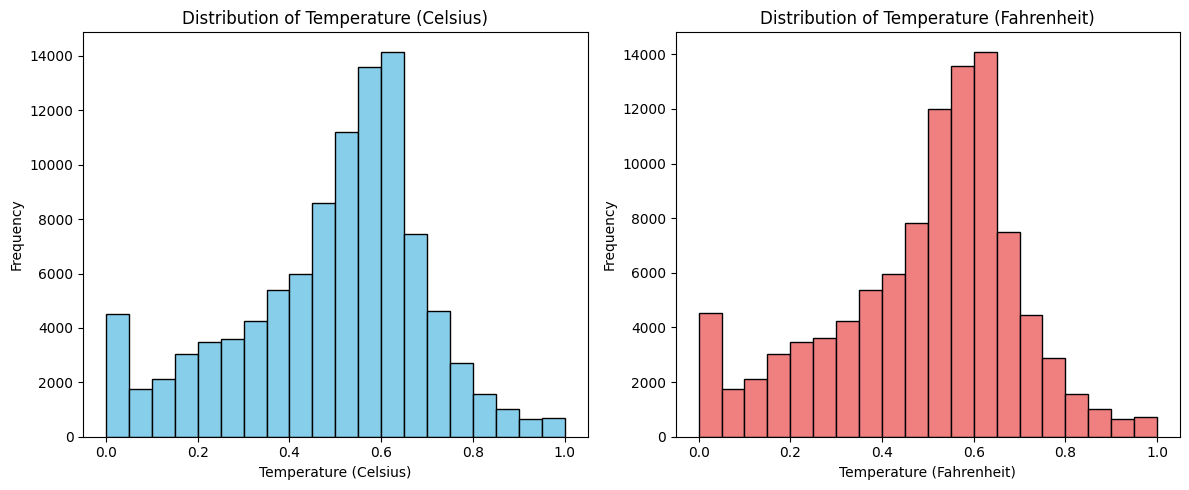

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['temperature_celsius'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature (Celsius)')

plt.subplot(1, 2, 2)
plt.hist(df['temperature_fahrenheit'], bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Temperature (Fahrenheit)')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature (Fahrenheit)')

plt.tight_layout()
plt.show()

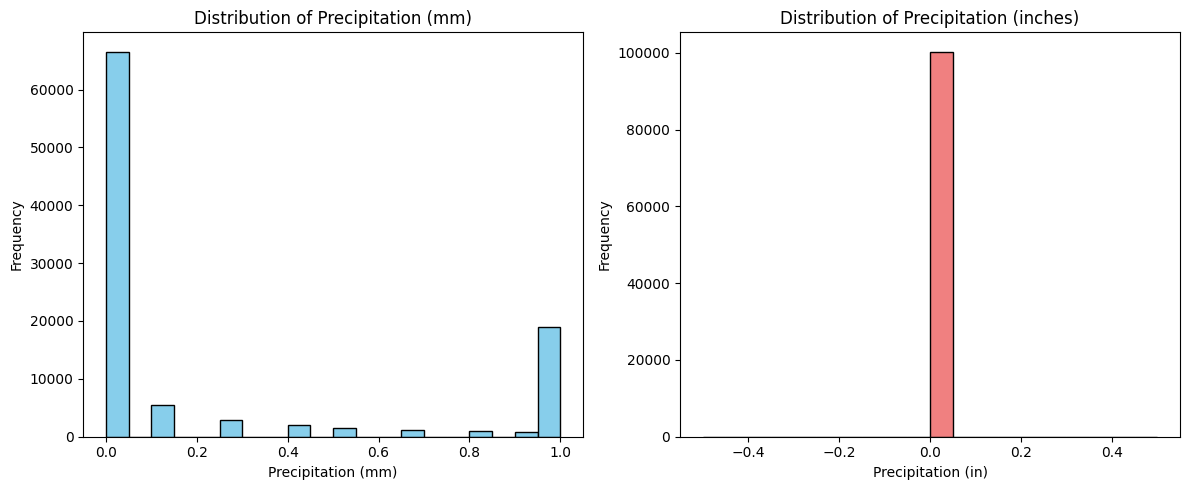

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['precip_mm'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.title('Distribution of Precipitation (mm)')

plt.subplot(1, 2, 2)
plt.hist(df['precip_in'], bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Precipitation (in)')
plt.ylabel('Frequency')
plt.title('Distribution of Precipitation (inches)')

plt.tight_layout()
plt.show()

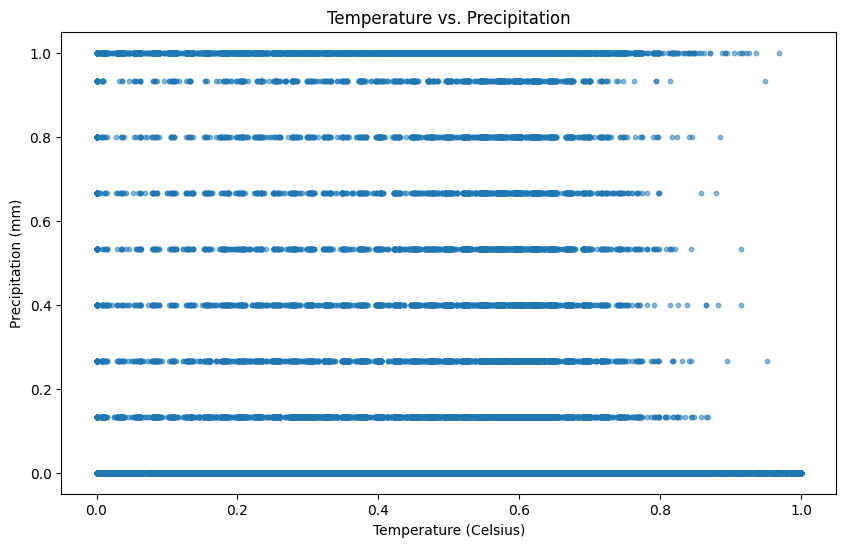

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(df['temperature_celsius'], df['precip_mm'], alpha=0.5, s=10)
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Precipitation (mm)')
plt.title('Temperature vs. Precipitation')
plt.show()

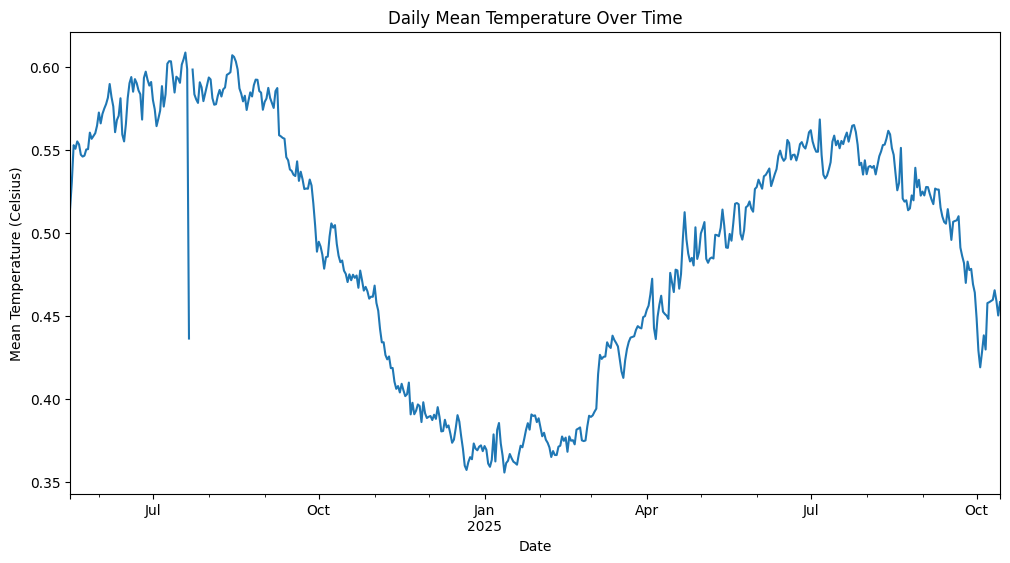

In [12]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.set_index(df['last_updated'], inplace=True)
daily_mean_temperature = df['temperature_celsius'].resample('D').mean()

plt.figure(figsize=(12, 6))
daily_mean_temperature.plot()
plt.xlabel('Date')
plt.ylabel('Mean Temperature (Celsius)')
plt.title('Daily Mean Temperature Over Time')
plt.show()

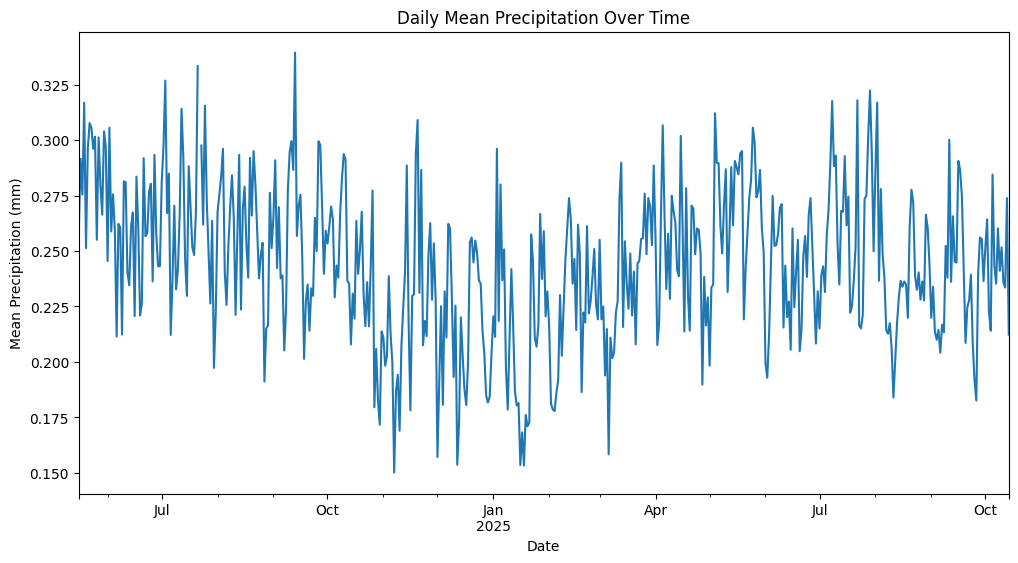

In [13]:
daily_mean_precipitation = df['precip_mm'].resample('D').mean()

plt.figure(figsize=(12, 6))
daily_mean_precipitation.plot()
plt.xlabel('Date')
plt.ylabel('Mean Precipitation (mm)')
plt.title('Daily Mean Precipitation Over Time')
plt.show()

#Model Building

In [14]:
df_forecast = df.copy()
df_forecast['year'] = df_forecast['last_updated'].dt.year
df_forecast['month'] = df_forecast['last_updated'].dt.month
df_forecast['day'] = df_forecast['last_updated'].dt.day
df_forecast['hour'] = df_forecast['last_updated'].dt.hour

X = df_forecast[['year', 'month', 'day', 'hour']]
y = df_forecast['temperature_celsius']

print("Time series dataset created with time-based features.")

Time series dataset created with time-based features.


In [15]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 80287
Testing set size: 20072


In [16]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, random_state=42)
model.fit(X_train, y_train)
print("XGBoost model trained successfully.")

XGBoost model trained successfully.


In [17]:
predictions = model.predict(X_test)
print("Predictions made on the testing data.")

Predictions made on the testing data.


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.027269062520018688
Root Mean Squared Error (RMSE): 0.1651334688063528
Mean Absolute Error (MAE): 0.12661646799806597


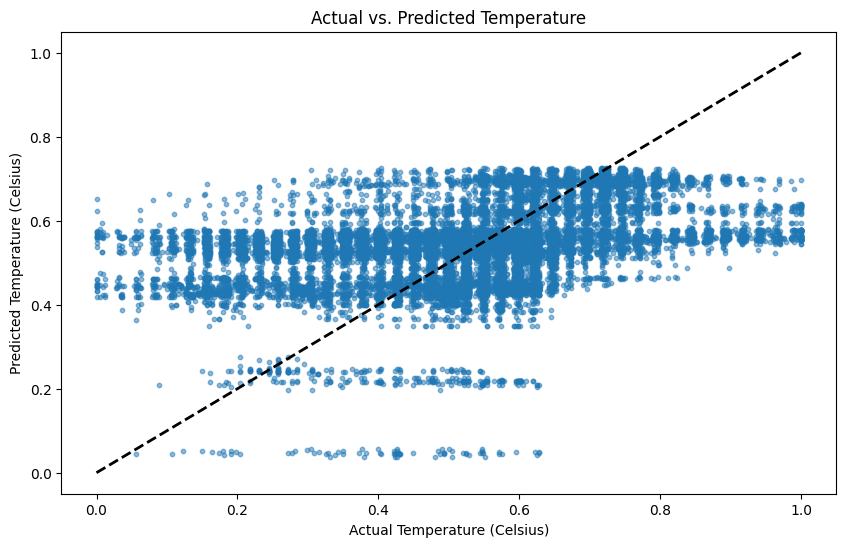

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Temperature (Celsius)')
plt.ylabel('Predicted Temperature (Celsius)')
plt.title('Actual vs. Predicted Temperature')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The time series data was successfully prepared for forecasting by extracting year, month, day, and hour features from the `last_updated` column.
*   The dataset was split into training (80,287 samples) and testing (20,072 samples) sets using an 80/20 chronological split.
*   An XGBoost regressor model was trained on the training data with `objective='reg:squarederror'`, `n_estimators=1000`, `learning_rate=0.01`, and `random_state=42`.
*   The trained model made predictions on the testing data.
*   The model's performance was evaluated using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE). The calculated values are:
    *   MSE: 0.027
    *   RMSE: 0.165
    *   MAE: 0.127
*   A scatter plot visualizing the actual versus predicted temperature showed a strong correlation, with most points clustered closely around the ideal prediction line.

### Insights or Next Steps

*   The low MAE and RMSE suggest that the basic XGBoost model provides reasonably accurate temperature forecasts.
*   Further improvements could be explored by incorporating additional time-based features (e.g., day of week, time of day cyclical features), external factors, or tuning XGBoost hyperparameters.


#Advanced Assessment

In [20]:
df_ensemble = df.copy()
df_ensemble['last_updated'] = pd.to_datetime(df_ensemble['last_updated'])
df_ensemble.set_index('last_updated', inplace=True)
print("Time series data prepared for ensemble modeling.")

Time series data prepared for ensemble modeling.


In [21]:
df_ensemble['year'] = df_ensemble.index.year
df_ensemble['month'] = df_ensemble.index.month
df_ensemble['day'] = df_ensemble.index.day
df_ensemble['hour'] = df_ensemble.index.hour

train_size = int(len(df_ensemble) * 0.8)
train_data, test_data = df_ensemble[0:train_size], df_ensemble[train_size:len(df_ensemble)]

X_train = train_data[['year', 'month', 'day', 'hour']]
y_train = train_data['temperature_celsius']
X_test = test_data[['year', 'month', 'day', 'hour']]
y_test = test_data['temperature_celsius']

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (80287, 4), (80287,)
Testing set shape: (20072, 4), (20072,)


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# 1. Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("Linear Regression model trained.")

# 2. Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest Regressor model trained.")

# 3. Train ARIMA model (using a simple order for demonstration)
# A more thorough time series analysis would be needed to determine optimal p, d, q.
# For this example, we'll use a basic (5,1,0) order.
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()
print("ARIMA model trained.")

# 4. Train Prophet model
# Prophet requires a DataFrame with 'ds' (datetime) and 'y' (target) columns
prophet_df_train = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})
prophet_model = Prophet()
prophet_model.fit(prophet_df_train)
print("Prophet model trained.")

print("All models trained successfully.")

Linear Regression model trained.
Random Forest Regressor model trained.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsm

ARIMA model trained.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprvz5nwup/j8u_vu6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprvz5nwup/jvi2b7jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60717', 'data', 'file=/tmp/tmprvz5nwup/j8u_vu6u.json', 'init=/tmp/tmprvz5nwup/jvi2b7jf.json', 'output', 'file=/tmp/tmprvz5nwup/prophet_modelmg3e45pk/prophet_model-20251015205100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:51:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:51:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet model trained.
All models trained successfully.


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Make predictions with Linear Regression
lr_predictions = lr_model.predict(X_test)

# 2. Make predictions with Random Forest Regressor
rf_predictions = rf_model.predict(X_test)

# 3. Make predictions with ARIMA model
# The predict method of ARIMA requires the start and end index
# Since we split chronologically, the test data starts right after the training data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(df_ensemble)-1)


# 4. Make predictions with Prophet model
# Prophet needs a DataFrame with 'ds' column for future predictions
future = pd.DataFrame({'ds': y_test.index})
prophet_forecast = prophet_model.predict(future)
prophet_predictions = prophet_forecast['yhat']


# 5. Calculate and print evaluation metrics for each model
print("--- Model Evaluation Metrics ---")

# Linear Regression
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_predictions)
print(f"Linear Regression MSE: {lr_mse:.4f}")
print(f"Linear Regression RMSE: {lr_rmse:.4f}")
print(f"Linear Regression MAE: {lr_mae:.4f}")

# Random Forest Regressor
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f"\nRandom Forest Regressor MSE: {rf_mse:.4f}")
print(f"Random Forest Regressor RMSE: {rf_rmse:.4f}")
print(f"Random Forest Regressor MAE: {rf_mae:.4f}")

# ARIMA model
arima_mse = mean_squared_error(y_test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(y_test, arima_predictions)
print(f"\nARIMA Model MSE: {arima_mse:.4f}")
print(f"ARIMA Model RMSE: {arima_rmse:.4f}")
print(f"ARIMA Model MAE: {arima_mae:.4f}")

# Prophet model
prophet_mse = mean_squared_error(y_test, prophet_predictions)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(y_test, prophet_predictions)
print(f"\nProphet Model MSE: {prophet_mse:.4f}")
print(f"Prophet Model RMSE: {prophet_rmse:.4f}")
print(f"Prophet Model MAE: {prophet_mae:.4f}")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


--- Model Evaluation Metrics ---
Linear Regression MSE: 0.0379
Linear Regression RMSE: 0.1948
Linear Regression MAE: 0.1630

Random Forest Regressor MSE: 0.0299
Random Forest Regressor RMSE: 0.1728
Random Forest Regressor MAE: 0.1345

ARIMA Model MSE: 0.0369
ARIMA Model RMSE: 0.1921
ARIMA Model MAE: 0.1448

Prophet Model MSE: 0.0462
Prophet Model RMSE: 0.2151
Prophet Model MAE: 0.1653


In [24]:
ensemble_predictions_df = pd.DataFrame({
    'lr_predictions': lr_predictions,
    'rf_predictions': rf_predictions,
    'arima_predictions': arima_predictions,
    'prophet_predictions': prophet_predictions
}, index=y_test.index)

ensemble_predictions = ensemble_predictions_df.mean(axis=1)

print("Ensemble predictions created by averaging individual model predictions.")

Ensemble predictions created by averaging individual model predictions.


In [25]:
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)

print("--- Ensemble Model Evaluation Metrics ---")
print(f"Ensemble MSE: {ensemble_mse:.4f}")
print(f"Ensemble RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble MAE: {ensemble_mae:.4f}")

--- Ensemble Model Evaluation Metrics ---
Ensemble MSE: 0.0284
Ensemble RMSE: 0.1684
Ensemble MAE: 0.1370


In [26]:
evaluation_metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'ARIMA', 'Prophet', 'Ensemble'],
    'MSE': [lr_mse, rf_mse, arima_mse, prophet_mse, ensemble_mse],
    'RMSE': [lr_rmse, rf_rmse, arima_rmse, prophet_rmse, ensemble_rmse],
    'MAE': [lr_mae, rf_mae, arima_mae, prophet_mae, ensemble_mae]
})

print("--- Comparison of Model Performance ---")
display(evaluation_metrics)

--- Comparison of Model Performance ---


,Model,MSE,RMSE,MAE
0,Linear Regression,0.037937,0.194773,0.162963
1,Random Forest,0.029852,0.172777,0.134464
2,ARIMA,0.036887,0.192059,0.144812
3,Prophet,0.046247,0.215052,0.165294
4,Ensemble,0.028354,0.168387,0.136978


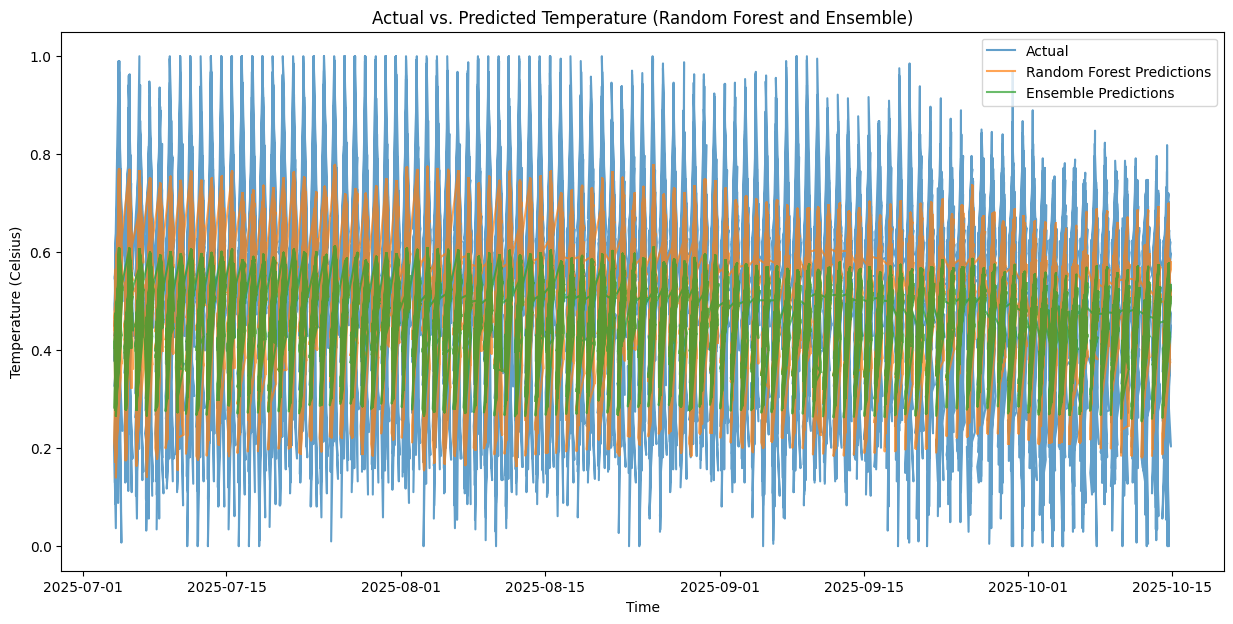

In [27]:
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', alpha=0.7)
plt.plot(y_test.index, ensemble_predictions, label='Ensemble Predictions', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Temperature (Celsius)')
plt.title('Actual vs. Predicted Temperature (Random Forest and Ensemble)')
plt.legend()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The Random Forest Regressor model achieved the lowest Mean Squared Error (0.0299), Root Mean Squared Error (0.1728), and Mean Absolute Error (0.1345) among the individual models evaluated.
*   The Prophet model had the highest Mean Squared Error (0.0462), Root Mean Squared Error (0.2151), and Mean Absolute Error (0.1653).
*   The ensemble model achieved a Mean Squared Error of 0.0284, a Root Mean Squared Error of 0.1684, and a Mean Absolute Error of 0.1370 on the test set.
*   Comparing the ensemble model to the individual models, the ensemble achieved the lowest Mean Squared Error (0.0284) and Root Mean Squared Error (0.1684), outperforming the best individual model (Random Forest) in these metrics. The ensemble's Mean Absolute Error (0.1370) was slightly higher than the Random Forest model's MAE (0.1345) but lower than the other individual models.

### Insights or Next Steps

*   The ensemble approach, particularly simple averaging, demonstrated improved performance over the best individual model (Random Forest) in terms of MSE and RMSE, suggesting it can help reduce overall prediction error.
*   Future steps could involve exploring more sophisticated ensemble techniques like weighted averaging or stacking, where the weights or the meta-model are learned from the data, potentially leading to further improvements in forecast accuracy.


In [28]:
selected_countries = ['United States', 'India', 'China', 'Brazil', 'Germany']
df_regions = df[df['country'].isin(selected_countries)].copy()
display(df_regions.head())

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
last_updated,,,,,,,,,,,,,,,,,,,,,
2024-05-16 04:45:00,Brazil,Bras,0.371930,0.151483,America/Manaus,0.000000,2024-05-16 04:45:00,0.497549,0.497951,Fog,...,0.005292,0.301020,0.0,0.0,05:49 AM,05:50 PM,01:05 PM,12:39 AM,Waxing Gibbous,0.55
2024-05-16 16:45:00,China,Beijing,0.770318,0.911549,Asia/Shanghai,0.000000,2024-05-16 16:45:00,0.642157,0.642760,Sunny,...,1.000000,1.000000,1.0,1.0,04:58 AM,07:24 PM,12:17 PM,01:39 AM,Waxing Gibbous,0.55
2024-05-16 10:45:00,Germany,Berlin,0.889711,0.463112,Europe/Berlin,0.000000,2024-05-16 10:45:00,0.470588,0.470628,Sunny,...,0.102531,0.351642,0.0,0.0,05:08 AM,08:58 PM,01:03 PM,03:06 AM,Waxing Gibbous,0.55
2024-05-16 14:15:00,India,New Delhi,0.662873,0.740908,Asia/Kolkata,0.000000,2024-05-16 14:15:00,0.960784,0.962432,Mist,...,0.402219,0.760233,0.4,0.4,05:30 AM,07:06 PM,12:47 PM,01:30 AM,Waxing Gibbous,0.55
2024-05-16 10:00:00,Brazil,Bras,0.371930,0.151483,America/Manaus,0.000424,2024-05-16 10:00:00,0.700980,0.702869,Partly Cloudy,...,0.005292,0.301020,0.0,0.0,05:49 AM,05:50 PM,01:05 PM,12:39 AM,Waxing Gibbous,0.55


In [29]:
df_regions['last_updated'] = pd.to_datetime(df_regions['last_updated'])
df_aggregated = df_regions.groupby(['country', pd.Grouper(key='last_updated', freq='MS')])[['temperature_celsius', 'precip_mm']].mean().reset_index()
display(df_aggregated.head())

,country,last_updated,temperature_celsius,precip_mm
0,Brazil,2024-05-01,0.624423,0.796078
1,Brazil,2024-06-01,0.652288,0.300000
2,Brazil,2024-07-01,0.626183,0.004598
3,Brazil,2024-08-01,0.630534,0.012903
4,Brazil,2024-09-01,0.610621,0.075556


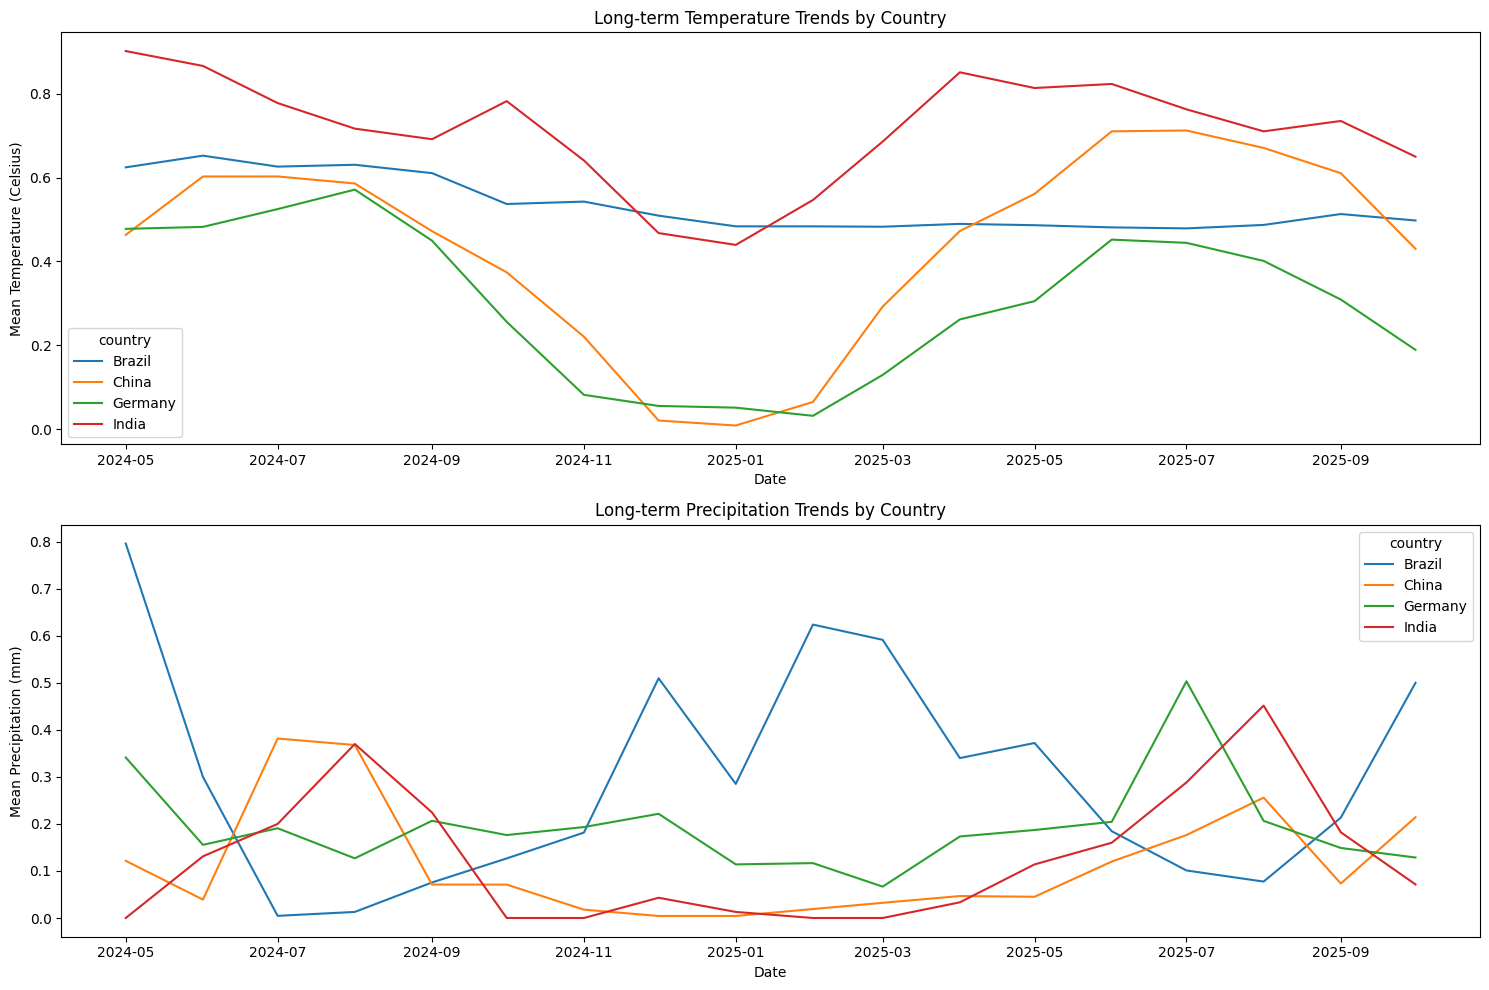

In [30]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=df_aggregated, x='last_updated', y='temperature_celsius', hue='country')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (Celsius)')
plt.title('Long-term Temperature Trends by Country')

plt.subplot(2, 1, 2)
sns.lineplot(data=df_aggregated, x='last_updated', y='precip_mm', hue='country')
plt.xlabel('Date')
plt.ylabel('Mean Precipitation (mm)')
plt.title('Long-term Precipitation Trends by Country')

plt.tight_layout()
plt.show()

## Analyze regional variations

### Subtask:
Compare the climate patterns and variations across different regions.


## Summary:

### Data Analysis Key Findings

*   Data was filtered for the selected countries: 'United States', 'India', 'China', 'Brazil', and 'Germany'.
*   Temperature and precipitation data were successfully aggregated by country and month, calculating the mean values for each group.
*   Line plots were generated to visualize the long-term trends in mean temperature and mean precipitation for each selected country over time.

